<a href="https://colab.research.google.com/github/bowei-yu/artificial_intelligence/blob/master/ai1/labs/AI1_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>04 Linear Regression and Feature Engineering</h1>

In [519]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [520]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

<h1>Introductory Remarks</h1>
<ul>
    <li>We're going to predict the strength of concrete again.</li>
    <li>But we'll do model selection as well as error estimation.</li>
    <li>And in the model selection, we'll try feature engineering.</li>
 </ul>

<h1>Read in and Check the Data</h1>

In [521]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/bowei-yu/artificial_intelligence/master/ai1/datasets/dataset_concrete.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [522]:
# The dimensions
df.shape

(1030, 9)

In [523]:
# The columns
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'strength'],
      dtype='object')

In [524]:
# The datatypes
df.dtypes

cement              float64
slag                float64
fly_ash             float64
water               float64
superplasticizer    float64
coarse_aggregate    float64
fine_aggregate      float64
age                   int64
strength            float64
dtype: object

In [525]:
# Maybe have a look at a few rows
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,194.7,0.0,100.5,170.2,7.5,998.0,901.8,56,43.39
1,153.6,144.2,112.3,220.1,10.1,923.2,657.9,28,16.50
2,252.0,0.0,0.0,185.0,0.0,1111.0,784.0,28,19.69
3,181.9,272.8,0.0,185.7,0.0,1012.4,714.3,7,12.37
4,333.0,0.0,0.0,192.0,0.0,931.2,842.6,90,41.68


In [526]:
# Summary statistics
df.describe(include="all")

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [527]:
features = ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']

<h1>Create a Test Set</h1>

In [528]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

<h1>Dataset Exploration</h1>

In [529]:
# It can be good to do this on a copy of the dataset (excluding the test set, of course)
copy_df = dev_df.copy()

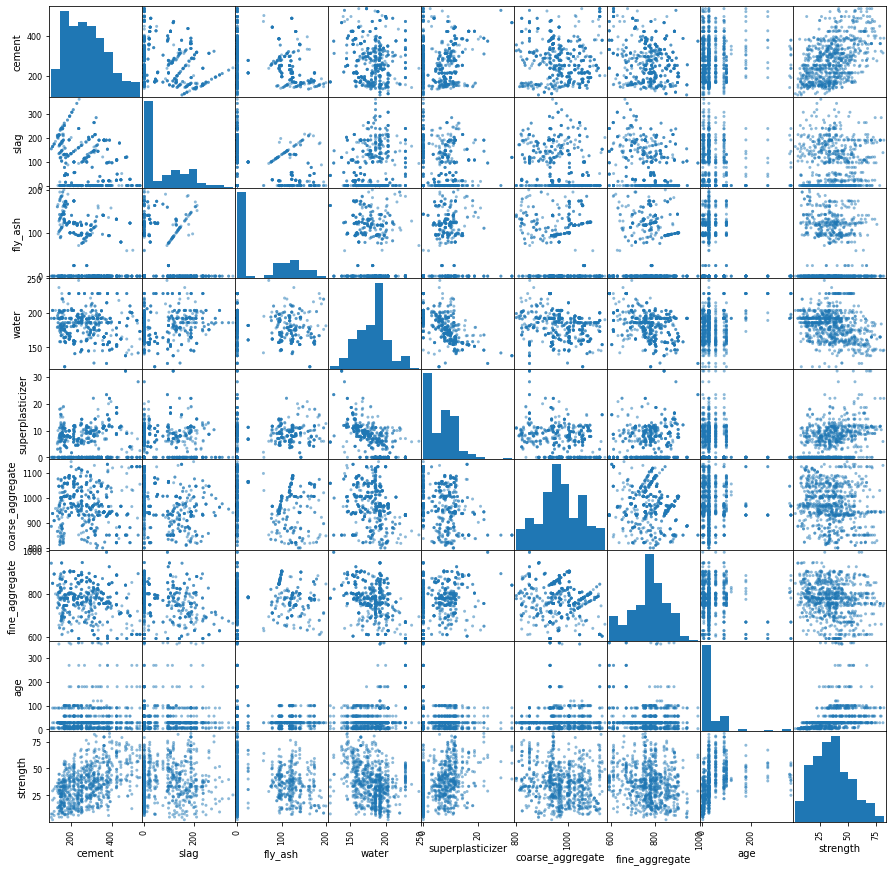

In [530]:
m = scatter_matrix(copy_df, figsize=(15, 15))

<ul>
    <li>For any that look interesting, we can draw a bigger scatter plot.
    </li>
</ul>

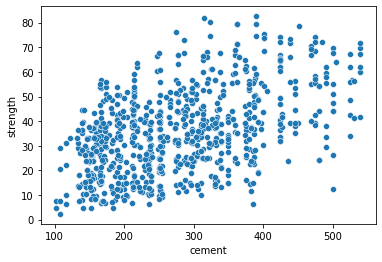

In [531]:
plot = scatterplot(x="cement", y="strength", data=copy_df)

<ul>
    <li>We can compute correlations between numeric-valued columns.</li>
    <li>Most common is Pearson correlation, which measures linear correlation. It value lies between +1 and −1. 
        A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total 
        negative linear correlation.
    </li>
</ul>

In [532]:
copy_df.corr()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
cement,1.000000,-0.265872,-0.368845,-0.074208,0.094885,-0.085483,-0.241458,0.054228,0.491461
slag,-0.265872,1.000000,-0.336454,0.118319,0.041492,-0.293590,-0.301793,-0.022790,0.143321
fly_ash,-0.368845,-0.336454,1.000000,-0.265362,0.390028,-0.052963,0.096389,-0.135268,-0.075848
water,-0.074208,0.118319,-0.265362,1.000000,-0.646000,-0.203483,-0.431066,0.258260,-0.286585
superplasticizer,0.094885,0.041492,0.390028,-0.646000,1.000000,-0.266334,0.200186,-0.177521,0.372800
coarse_aggregate,-0.085483,-0.293590,-0.052963,-0.203483,-0.266334,1.000000,-0.165146,0.007115,-0.160208
fine_aggregate,-0.241458,-0.301793,0.096389,-0.431066,0.200186,-0.165146,1.000000,-0.146157,-0.187260
age,0.054228,-0.022790,-0.135268,0.258260,-0.177521,0.007115,-0.146157,1.000000,0.334132
strength,0.491461,0.143321,-0.075848,-0.286585,0.372800,-0.160208,-0.187260,0.334132,1.000000


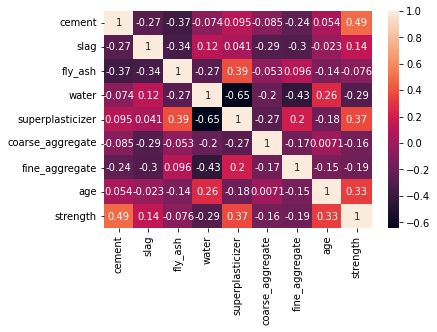

In [533]:
heatmap(copy_df.corr(), annot=True)

<ul>
    <li>We can add other features, ones that are computed from the existing features &mdash; we call this
        <b>feature engineering</b>. 
        <ul>
            <li>In general, these new features might be products or ratios of existing features.</li>
            <li>Or they might result from applying functions to existing features, e.g. squaring, square rooting,
                taking the log, &hellip;
            </li>
            <li>If you're going to be learning a linear model then it will not be useful to the linear model to add or subtract features or to multiply or divide by a scalar,
                since this just gives new features that are linearly correlated with existing features.
            </li>
        </ul>
        We can then produce visualizations and compute correlations to
        see whether these new features are predictive or not.
    </li>
</ul>

In [560]:
# This is the water/cement ratio, so I'll call it wcr
copy_df["wcr"] = copy_df["water"] / copy_df["cement"]

copy_df["scr"] = copy_df["superplasticizer"] / copy_df["cement"]
copy_df["slcr"] = copy_df["slag"] / copy_df["cement"]
copy_df["fcr"] = copy_df["fly_ash"] / copy_df["cement"]
copy_df["ccr"] = copy_df["coarse_aggregate"] / copy_df["cement"]
copy_df["fcr"] = copy_df["fine_aggregater"] / copy_df["cement"]
copy_df["acr"] = copy_df["age"] / copy_df["cement"]

copy_df["swr"] = copy_df["superplasticizer"] / copy_df["water"]
copy_df["cfr"] = copy_df["cement"]/ (copy_df["coarse_aggregate"] + copy_df["fine_aggregate"])
copy_df["cor"] = copy_df["cement"] / (copy_df["slag"] + copy_df["fine_aggregate"] + copy_df["coarse_aggregate"] + copy_df["fly_ash"] + copy_df["water"] + copy_df["superplasticizer"] + copy_df["age"])

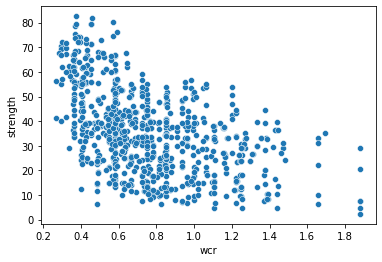

In [535]:
plot = scatterplot(x="wcr", y="strength", data=copy_df)

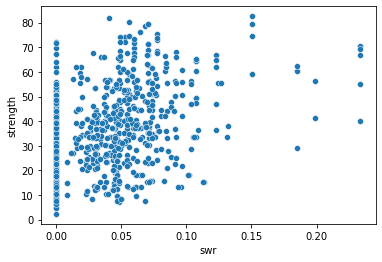

In [561]:
plot = scatterplot(x="swr", y="strength", data=copy_df)

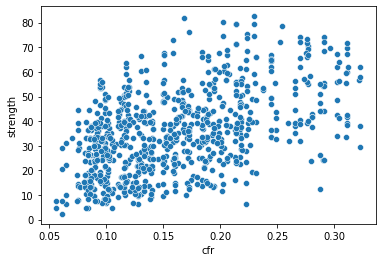

In [537]:
plot = scatterplot(x="cfr", y="strength", data=copy_df)

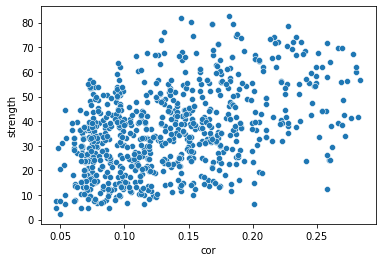

In [538]:
plot = scatterplot(x="cor", y="strength", data=copy_df)

In [568]:
copy_df.corr()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength,wcr,swr,cfr,cor
cement,1.000000,-0.265872,-0.368845,-0.074208,0.094885,-0.085483,-0.241458,0.054228,0.491461,-0.881791,0.131763,0.987677,0.994582
slag,-0.265872,1.000000,-0.336454,0.118319,0.041492,-0.293590,-0.301793,-0.022790,0.143321,0.350452,0.031919,-0.191511,-0.268429
fly_ash,-0.368845,-0.336454,1.000000,-0.265362,0.390028,-0.052963,0.096389,-0.135268,-0.075848,0.225326,0.329399,-0.347776,-0.362836
water,-0.074208,0.118319,-0.265362,1.000000,-0.646000,-0.203483,-0.431066,0.258260,-0.286585,0.334686,-0.695774,0.006202,-0.036137
superplasticizer,0.094885,0.041492,0.390028,-0.646000,1.000000,-0.266334,0.200186,-0.177521,0.372800,-0.221184,0.988462,0.094267,0.073879
coarse_aggregate,-0.085483,-0.293590,-0.052963,-0.203483,-0.266334,1.000000,-0.165146,0.007115,-0.160208,-0.048050,-0.229001,-0.178529,-0.112961
fine_aggregate,-0.241458,-0.301793,0.096389,-0.431066,0.200186,-0.165146,1.000000,-0.146157,-0.187260,0.077584,0.231800,-0.327049,-0.261410
age,0.054228,-0.022790,-0.135268,0.258260,-0.177521,0.007115,-0.146157,1.000000,0.334132,-0.007641,-0.158809,0.072011,-0.001205
strength,0.491461,0.143321,-0.075848,-0.286585,0.372800,-0.160208,-0.187260,0.334132,1.000000,-0.496855,0.385496,0.506109,0.450560
wcr,-0.881791,0.350452,0.225326,0.334686,-0.221184,-0.048050,0.077584,-0.007641,-0.496855,1.000000,-0.265314,-0.840525,-0.856181


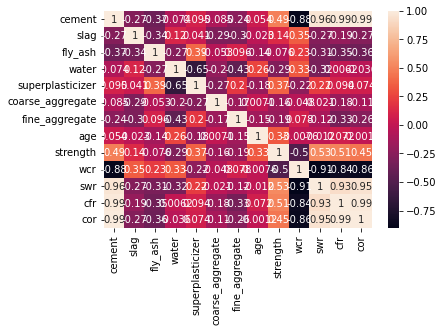

In [540]:
heatmap(copy_df.corr(), annot=True)

<ul>
    <li>E.g. this new feature is quite predictive of strength, but highly correlated with cement.</li>
</ul>

<p>
    <strong>Now, it's your turn!</strong> Think about the features; Google them perhaps. Invent new features
    that you think. might be interesting. Draw scatter plots for strength against these new features; look
    at correlations.
</p>

<h1>Model Selection</h1>

<p>
    If you found any interesting features, write a class based on the one below.
</p>

In [541]:
class InsertWCR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["wcr"] = X["water"] / X["cement"]
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["cement", "water"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [542]:
class InsertCOR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["cor"] = X["cement"] / (X["slag"] + X["fine_aggregate"] + X["coarse_aggregate"] + X["fly_ash"] + X["water"] + X["superplasticizer"] + X["age"])
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["cement", "water"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [563]:
class InsertSWR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["swr"] = X["superplasticizer"] / X["water"]
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["cement", "water"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [548]:
class InsertCFR(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["cfr"] = X["cement"]/ (X["coarse_aggregate"] + X["fine_aggregate"])
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["cement", "water"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

<p>
    Now write a preprocessor like this one:
</p>

In [564]:
preprocessor = ColumnTransformer([
        ("features", Pipeline([("wcr", InsertWCR()),
                               ("cor", InsertCOR()),
                               ("swr", InsertSWR()),
                               ("cfr", InsertCFR()),
                               ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean"))]), 
                     features)],
        remainder="passthrough")

In [565]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, converted to a 1D numpy array
dev_y = dev_df["strength"].values
test_y = test_df["strength"].values

In [566]:
# Create a pipeline that combines the preprocessor with linear regression
ols = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", LinearRegression())])

# Create a dictionary of hyperparameters
ols_param_grid = {"preprocessor__features__wcr__insert": [True, False], 
                  "preprocessor__features__cor__insert": [True, False],
                  "preprocessor__features__swr__insert": [True, False],
                  "preprocessor__features__cfr__insert": [True, False]}

# Create the grid search object which will find the best hyperparameter values based on validation error
ols_gs = GridSearchCV(ols, ols_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. . It will also re-train on train+validation using the best parameters.
ols_gs.fit(dev_X, dev_y)

# Let's see how well we did
ols_gs.best_params_, ols_gs.best_score_

({'preprocessor__features__cfr__insert': False,
  'preprocessor__features__cor__insert': True,
  'preprocessor__features__swr__insert': True,
  'preprocessor__features__wcr__insert': True},
 -7.997849133786788)

<p>
    You can tweak and tune as much as you like!
    Keep doing this until you find a good model.
</p>
<p>
    Add an extra cell to create a pipeline that uses kNN instead of linear regression. Note that your
    parameter grid will now need to include values for $k$. Play around with this until you find a good model.
</p>
<p>
    Don't go on to the next step until told to do so.
</p>

<h1>Evaluate on the Test Set</h1>
<p>
    Once you've finished tweaking and tuning, then, using the best model(s) we found, we can do error estimation 
    on the test set.
</p>

In [567]:
# Now test on the test set
mean_absolute_error(test_y, ols_gs.predict(test_X))

8.158507156739688

<p>
    Did anyone do better than this?
</p>

In [547]:
# water to slag, water / everyth else added tgt, water divided by all the dry stuff. divide by age (or get log of it to make it linear), actual ratio of making a cement,